In [1]:
import json
import numpy as np
import pandas as pd
import math
from tabulate import tabulate
from compute_tools import *
from view_tools import *

### Get Groundtruth Labels
Skip if not generating for the first time.

In [2]:
# gt_file='/home/ec2-user/segmenter/ETTDATA/Test/downsized/MIMIC/annotations/test_annotations_enl5.json'
# with open(gt_file) as f:
#     gt_data = json.load(f)

# gt_labels = []
# for anno in gt_data['annotations']:
#     bbox = anno['bbox']
#     x = bbox[0] + bbox[2] / 2
#     y = bbox[1] + bbox[3] / 2
#     gt_labels.append([anno['image_id'], anno['category_id'], x, y])
# gt_df = pd.DataFrame(gt_labels, columns=['image_id', 'category_id', 'x', 'y'])
# gt_df.to_csv("labels/gt_labels_mimic.csv", index=False)    

gt_file='/home/ec2-user/segmenter/ETTDATA/train_mimic_only/annotations/val_annotations_enl5.json'
with open(gt_file) as f:
    gt_data = json.load(f)

gt_labels = []
for anno in gt_data['annotations']:
    bbox = anno['bbox']
    x = bbox[0] + bbox[2] / 2
    y = bbox[1] + bbox[3] / 2
    gt_labels.append([anno['image_id'], anno['category_id'], x, y])
gt_df = pd.DataFrame(gt_labels, columns=['image_id', 'category_id', 'x', 'y'])
gt_df.to_csv("labels/gt_labels_mimic_only_val.csv", index=False)   

### Get Predicted Labels

In [2]:
def get_max_pred_bbox(pred_file='mask_rcnn_test-dev_results.bbox.json'):
    with open(pred_file) as f:
        data = json.load(f)
        max_score = {}
        for pred in data:
            key = (pred['image_id'], pred['category_id'])
            if key not in max_score.keys():
                max_score[key] = [pred]
            elif pred['category_id'] == 3046 or pred['category_id'] == 3047:
                if pred['score'] > max_score[key][0]['score']:
                    max_score[key] = [pred]
            # elif pred['category_id'] == 3048:
            #     curr = max_score[key]
            #     if len(curr) < 2:
            #         curr.append(pred)
            #     elif pred['score'] > min(curr[0]['score'], curr[1]['score']):
            #             if curr[0]['score'] < curr[1]['score']:
            #                 curr[0] = pred
            #             else:
            #                 curr[1] = pred
    return max_score

In [3]:
def get_labels(max_score, thres=0.3):
    pred_labels = []
    for item in max_score:
        item=item[0]
        if item['score'] > thres:
            x = item['bbox'][0] + item['bbox'][2]/2
            y = item['bbox'][1] + item['bbox'][3]/2
            pred_labels.append([item['image_id'], item['category_id'], x, y])
    pred_labels = pd.DataFrame(data=pred_labels, columns=["image_id", "category_id", "x", "y"])
    return pred_labels

In [5]:
# Test model with gloria added
pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results_gloria/test_gloria_mimic.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_mimic = get_labels(max_score, thres=0.3)
pred_mimic.to_csv("test_results_gloria/pred_labels_mimic.csv", index=False)

pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results_gloria/test_gloria_ranzcr.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_mimic = get_labels(max_score, thres=0.3)
pred_mimic.to_csv("test_results_gloria/pred_labels_ranzcr.csv", index=False)

In [36]:
pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/mimic-only-mimic.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_mimic = get_labels(max_score, thres=0.3)
pred_mimic.to_csv("labels/train_mimic_only/pred_labels_mimic.csv", index=False)

pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/sampled-data-mimic.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_mimic = get_labels(max_score, thres=0.3)
pred_mimic.to_csv("labels/sampled_data_split/pred_labels_mimic.csv", index=False)

pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/all-data-mimic.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_mimic = get_labels(max_score, thres=0.3)
pred_mimic.to_csv("labels/all_data_split/pred_labels_mimic.csv", index=False)

In [35]:
pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/mimic-only-ranzcr.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_ranzcr = get_labels(max_score, thres=0.3)
pred_ranzcr.to_csv("labels/train_mimic_only/pred_labels_ranzcr.csv", index=False)

pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/sampled-data-ranzcr.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_ranzcr = get_labels(max_score, thres=0.3)
pred_ranzcr.to_csv("labels/sampled_data_split/pred_labels_ranzcr.csv", index=False)

pred_file='/home/ec2-user/segmenter/InternImage/detection/test_results/all-data-ranzcr.bbox.json'
max_score = get_max_pred_bbox_3cls(pred_file)
max_score = list(max_score.values())
pred_ranzcr = get_labels(max_score, thres=0.3)
pred_ranzcr.to_csv("labels/all_data_split/pred_labels_ranzcr.csv", index=False)

## Evaluate

In [2]:
import sys
sys.path.append('../../ETT_Evaluation')
from eval.eval import ETTEvaler

In [3]:
# Test model with gloria added
evaler = ETTEvaler("labels/gt_labels_mimic.csv", "test_results_gloria/pred_labels_mimic.csv", 1280)

tp, fp, tn, fn, distances = evaler.gt_pred_distance(target='tip')
print(np.mean(distances))
evaler.get_metrics(tp, fp, tn, fn, distances, cat='tip')

np.random.seed(102)
B = 100
mean_tip_dis = []
tip_carina_mean_err = []
for i in range(B):
    random_idx = np.random.randint(0, len(distances), len(distances))
    boot_dis = [distances[i] for i in random_idx]
    mean_tip_dis.append(np.mean(boot_dis))
mean_tip_ci = np.percentile(mean_tip_dis, [2.5, 97.5])
print(mean_tip_ci)

0.24919229649067381
**************************************
Max tip distance:  1.8605420895026148
Min tip distance:  0.008596945668709926
Mean tip distance:  0.24919229649067381
Std tip distance:  0.24259930473307217
Median tip distance:  0.17964727836622438
**************************************
Precision:  0.9941860465116279
Recall:  0.501466275659824
Sensitivity:  0.501466275659824
Specificity:  0.95
F1 score:  0.6666666666666666
+--------+-------+----------+
|        |   tip |   No tip |
+========+=======+==========+
| tip    |   171 |        1 |
+--------+-------+----------+
| No tip |   170 |       19 |
+--------+-------+----------+
[0.21019308 0.28507976]


(array([94., 34., 32.,  7.,  1.,  0.,  1.,  1.,  0.,  1.]),
 array([0.00859695, 0.19379146, 0.37898597, 0.56418049, 0.749375  ,
        0.93456952, 1.11976403, 1.30495855, 1.49015306, 1.67534758,
        1.86054209]),
 <BarContainer object of 10 artists>)

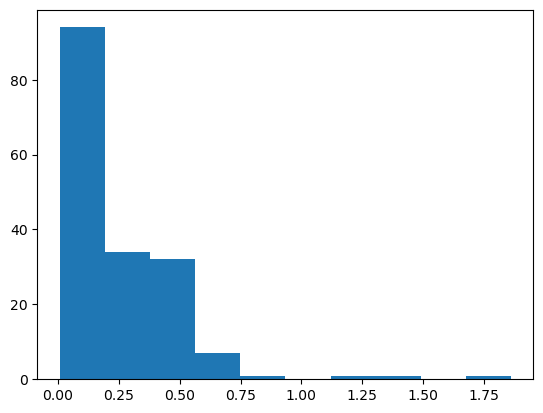

In [4]:
plt.hist(distances)

In [14]:
# evaler = ETTEvaler("labels/gt_labels_mimic.csv", "labels/all_data_split/pred_labels_mimic.csv", 1280)
# evaler = ETTEvaler("labels/gt_labels_ranzcr.csv", "labels/all_data_split/pred_labels_ranzcr.csv", 1280)
# evaler = ETTEvaler("labels/gt_labels_mimic.csv", "labels/sampled_data_split/pred_labels_mimic.csv", 1280)
# evaler = ETTEvaler("labels/gt_labels_ranzcr.csv", "labels/sampled_data_split/pred_labels_ranzcr.csv", 1280)
# evaler = ETTEvaler("labels/gt_labels_mimic.csv", "labels/train_mimic_only/pred_labels_mimic.csv", 1280)
# evaler = ETTEvaler("labels/gt_labels_ranzcr.csv", "labels/train_mimic_only/pred_labels_ranzcr.csv", 1280)

tp, fp, tn, fn, distances_all = evaler.gt_pred_distance(target='tip')
print(np.mean(distances))
evaler.get_metrics(tp, fp, tn, fn, distances, cat='tip')

np.random.seed(102)
B = 100
mean_tip_dis = []
tip_carina_mean_err = []
for i in range(B):
    random_idx = np.random.randint(0, len(distances), len(distances))
    boot_dis = [distances[i] for i in random_idx]
    mean_tip_dis.append(np.mean(boot_dis))
mean_tip_ci = np.percentile(mean_tip_dis, [2.5, 97.5])
print(mean_tip_ci)

0.3202482191074174
**************************************
Max tip distance:  2.3935765947061443
Min tip distance:  0.01438510879213134
Mean tip distance:  0.3202482191074174
Std tip distance:  0.4410320301196825
Median tip distance:  0.19213109596308725
**************************************
Precision:  1.0
Recall:  0.6608695652173913
Sensitivity:  0.6608695652173913
Specificity:  1.0
F1 score:  0.7958115183246073
+--------+-------+----------+
|        |   tip |   No tip |
+========+=======+==========+
| tip    |    76 |        0 |
+--------+-------+----------+
| No tip |    39 |       23 |
+--------+-------+----------+
[0.19346085 0.55961747]


Text(4, 30, 'number of tp = 29')

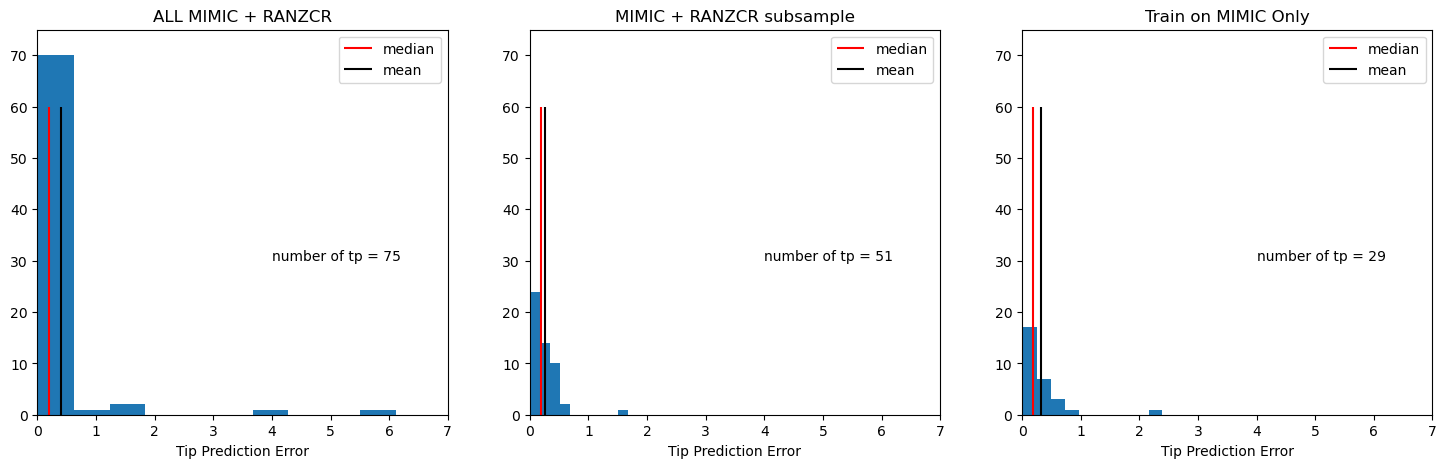

In [24]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=[18, 5])

axes[0].hist(distances_all)
axes[0].vlines(np.median(distances_all), ymin=0, ymax=60, label='median', color='red')
axes[0].vlines(np.mean(distances_all), ymin=0, ymax=60, label='mean', color='black')
axes[0].set_title("ALL MIMIC + RANZCR")
axes[0].set_xlim(0, 7)
axes[0].set_ylim(0, 75)
axes[0].set_xlabel("Tip Prediction Error")
axes[0].legend()
axes[0].text(4, 30, f'number of tp = {len(distances_all)}')


axes[1].hist(distances_sub)
axes[1].vlines(np.median(distances_sub), ymin=0, ymax=60, label='median', color='red')
axes[1].vlines(np.mean(distances_sub), ymin=0, ymax=60, label='mean', color='black')
axes[1].set_title("MIMIC + RANZCR subsample")
axes[1].set_xlim(0, 7)
axes[1].set_ylim(0, 75)
axes[1].set_xlabel("Tip Prediction Error")
axes[1].legend()
axes[1].text(4, 30, f'number of tp = {len(distances_sub)}')

axes[2].hist(distances)
axes[2].vlines(np.median(distances), ymin=0, ymax=60, label='median', color='red')
axes[2].vlines(np.mean(distances), ymin=0, ymax=60, label='mean', color='black')
axes[2].set_title("Train on MIMIC Only")
axes[2].set_xlim(0, 7)
axes[2].set_ylim(0, 75)
axes[2].set_xlabel("Tip Prediction Error")
axes[2].legend()

axes[2].text(4, 30, f'number of tp = {len(distances)}')

In [59]:
gt_tc = evaler.tip_carina_distance(gt=True)
pred_tc = evaler.tip_carina_distance(gt=False)

Processing groundtruth label...
Tip not exist for image  4425991
Tip not exist for image  4425993
Tip not exist for image  4426004
Tip not exist for image  4426032
Tip not exist for image  4426049
Tip not exist for image  4426081
Tip not exist for image  4426112
Tip not exist for image  4426173
Tip not exist for image  4426183
Tip not exist for image  4426195
Tip not exist for image  4426251
Tip not exist for image  4426254
Tip not exist for image  4426280
Tip not exist for image  4426303
Tip not exist for image  4426344
Tip not exist for image  4426353
Tip not exist for image  4426392
Tip not exist for image  4426418
Tip not exist for image  4426419
Tip not exist for image  4426420
Tip not exist for image  4426421
Tip not exist for image  4426422
Tip not exist for image  4426423
Tip not exist for image  4426424
Tip not exist for image  4426425
Tip not exist for image  4426426
Tip not exist for image  4426427
Tip not exist for image  4426428
Tip not exist for image  4426429
Tip not exi

In [60]:
evaler.mean_squared_error(gt_tc, pred_tc)

0.6115582390830152

In [61]:
evaler.calculate_r_squared(gt_tc, pred_tc)

0.8655423503665611